<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
#For use during testing:
#!pip install leidenalg
#!pip install --index-url https://test.pypi.org/simple/ modisco

!pip install modisco

In [1]:
from __future__ import print_function, division
%matplotlib inline
/
try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
import os

## Grab the input data

In [4]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [3]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict
import numpy as np

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #len(fasta_sequences) #100 #since this is just a test run, for speed I am limiting to 100 sequences
#reverse-complement some of the sequences to simulate that
take_rc = (np.random.RandomState(1234).uniform(size=n) > 0.5)
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                            for x,rc in zip(f['contrib_scores'][task][:n], take_rc)]
    task_to_hyp_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                                for x,rc in zip(f['hyp_contrib_scores'][task][:n], take_rc)]

onehot_data = [one_hot_encode_along_channel_axis(seq) if not rc else
               one_hot_encode_along_channel_axis(seq)[::-1,::-1]
               for seq,rc in zip(fasta_sequences[:n], take_rc)]

Double check by plotting

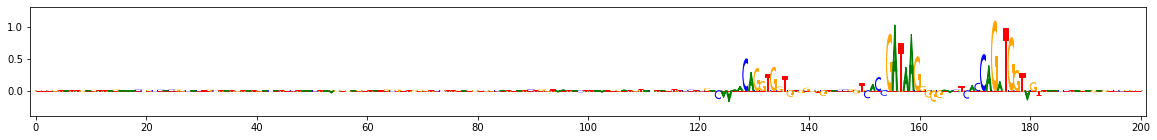

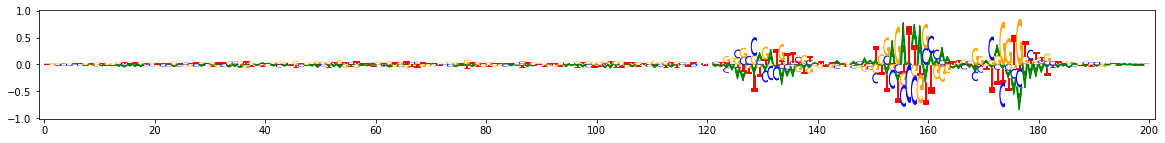

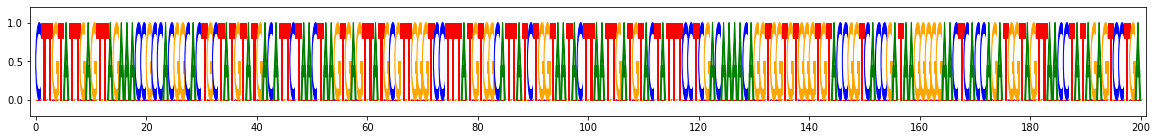

In [15]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. If all three tasks are specified under "task_names", then there will be 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). If only task0 is specified, there will only be two possible metaclusters (+1 and -1). In recent years, we have moved towards running tfmodisco on a single task at a time, which is why the example below just uses task0 (which turns up both the TAL and GATA motifs).

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.288980992
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02277598052151734
Computing threshold
For increasing = True , the minimum IR precision was 0.14668684157935308 occurring at 7.078051567077637e-06 implying a frac_neg of 0.17190270668138782
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4483100377790805 occurring at -1.0013580322265625e-05 implying a frac_neg of 0.812612279502665
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -1.0124836564064026  and  0.898599348962307 with frac passing 0.15951612903225806
Final raw thresholds are -1.0124836564064026  and  0.898599348962307
Final transformed thresholds are -0.8494086021505376  and  0.8400537634408602


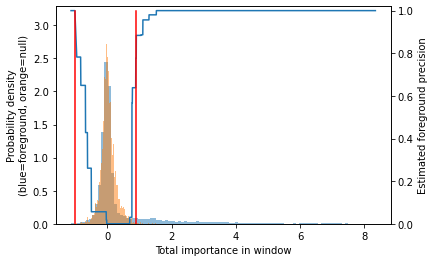

Got 198 coords
After resolving overlaps, got 198 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8399537634408603
MEMORY 0.288997376
198 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [195]
Idx to activities:  {0: '1'}
MEMORY 0.288997376
On metacluster 0
Metacluster size 195
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 195
(Round 1) Computing coarse affmat
MEMORY 0.288997376
Beginning embedding computation
MEMORY 0.288997376


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 188 out of 195 | elapsed:    6.0s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 195 out of 195 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 188 out of 195 | elapsed:    5.8s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 195 out of 195 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.03426098823547363 s
Constructing csr matrix...
csr matrix made in 0.0341489315032959 s
Finished embedding computation in 13.18 s
MEMORY 0.289026048
Starting affinity matrix computations
MEMORY 0.289026048
Batching in slices of size 195


[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    0.4s finished
100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

Finished affinity matrix computations in 1.74 s
MEMORY 0.289026048
(Round 1) Computed coarse affmat
MEMORY 0.289026048
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.289026048
Launching nearest neighbors affmat calculation job
MEMORY 0.289026048


Parallel runs completed
MEMORY 0.289026048
Job completed in: 0.42 s
MEMORY 0.289026048
Launching nearest neighbors affmat calculation job
MEMORY 0.289026048
Parallel runs completed
MEMORY 0.289026048
Job completed in: 0.42 s
MEMORY 0.289026048
(Round 1) Computed affinity matrix on nearest neighbors in 0.92 s
MEMORY 0.289026048
Filtered down to 192 of 195
(Round 1) Retained 192 rows out of 195 after filtering
MEMORY 0.289026048
(Round 1) Computing density adapted affmat
MEMORY 0.289026048
[t-SNE] Computed conditional probabilities for sample 192 / 192
[t-SNE] Mean sigma: 0.233430
(Round 1) Computing clustering
MEMORY 0.289026048
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s


Quality: 0.5446770763667007
Quality: 0.546016425319298
Got 7 clusters after round 1
Counts:
{6: 3, 5: 6, 2: 39, 1: 46, 3: 14, 0: 73, 4: 11}
MEMORY 0.289026048
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.289026048
Aggregating for cluster 0 with 73 seqlets
MEMORY 0.289026048
Skipped 6 seqlets that went over sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 66
Skipped 2 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 46 seqlets
MEMORY 0.289026048
Skipped 6 seqlets that went over sequence edge during flank expansion
Skipped 2 due to duplicates
Trimming eliminated 0 seqlets out of 38
Skipped 4 seqlets that went over the sequence edge during flank expansion


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.5s finished


Aggregating for cluster 2 with 39 seqlets
MEMORY 0.289026048
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 2 seqlets that went over sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 35
Skipped 5 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 3 with 14 seqlets
MEMORY 0.289026048
Skipped 1 seqlets that went over the sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 13
Aggregating for cluster 4 with 11 seqlets
MEMORY 0.289026048
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 9
Aggregating for cluster 5 with 6 seqlets
MEMORY 0.289026048
Trimming eliminated 0 seqlets out of 6
Skipped 2 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 6 with 3 seqlets
MEMORY 0.289026048
T

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 150 out of 157 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 157 out of 157 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 150 out of 157 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 157 out of 157 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.034388065338134766 s
Constructing csr matrix...
csr matrix made in 0.027324199676513672 s
Finished embedding computation in 9.99 s
MEMORY 0.289329152
Starting affinity matrix computations
MEMORY 0.289329152
Batching in slices of size 157


[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:    0.3s finished
100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

Finished affinity matrix computations in 1.73 s
MEMORY 0.289329152
(Round 2) Computed coarse affmat
MEMORY 0.289329152
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.289329152
Launching nearest neighbors affmat calculation job
MEMORY 0.289329152


Parallel runs completed
MEMORY 0.289329152
Job completed in: 0.34 s
MEMORY 0.289329152
Launching nearest neighbors affmat calculation job
MEMORY 0.289329152
Parallel runs completed
MEMORY 0.289329152
Job completed in: 0.33 s
MEMORY 0.289329152
(Round 2) Computed affinity matrix on nearest neighbors in 0.75 s
MEMORY 0.289329152
Not applying filtering for rounds above first round
MEMORY 0.289329152
(Round 2) Computing density adapted affmat
MEMORY 0.289329152
[t-SNE] Computed conditional probabilities for sample 157 / 157
[t-SNE] Mean sigma: 0.241494
(Round 2) Computing clustering
MEMORY 0.289329152
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s


Quality: 0.536278941231442
Quality: 0.5369516265470341
Got 6 clusters after round 2
Counts:
{0: 51, 4: 4, 3: 21, 1: 43, 2: 36, 5: 2}
MEMORY 0.289329152
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.289329152
Aggregating for cluster 0 with 51 seqlets
MEMORY 0.289329152
Trimming eliminated 0 seqlets out of 51
Aggregating for cluster 1 with 43 seqlets
MEMORY 0.289337344
Trimming eliminated 0 seqlets out of 43
Aggregating for cluster 2 with 36 seqlets
MEMORY 0.289337344


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.2s finished


Trimming eliminated 0 seqlets out of 36
Skipped 3 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 3 with 21 seqlets
MEMORY 0.289337344
Trimming eliminated 0 seqlets out of 21
Aggregating for cluster 4 with 4 seqlets
MEMORY 0.289357824
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 3
Aggregating for cluster 5 with 2 seqlets
MEMORY 0.289357824
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 1
Got 6 clusters
Splitting into subclusters...
MEMORY 0.289357824
Inspecting pattern 0 for spurious merging
Inspecting pattern 1 for spurious merging
Inspecting pattern 2 for spurious merging
Inspecting pattern 3 for spurious merging
Inspecting pattern 4 for spurious merging
Inspecting pattern 5 for spurious merging
Merging on 6 clusters
MEMORY 0.289357824
On merging iteration 1
Numbers for each pattern pre-subsample: [51, 43, 33, 21, 3, 1]
Numbers after subsampling: [51, 43, 33, 21, 3, 1]
Computing sims for pattern 0
Computed 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Iteration 600: error = 0.7675616, gradient norm = 0.0006598 (50 iterations in 0.016s)
[t-SNE] Iteration 650: error = 0.7202026, gradient norm = 0.0004432 (50 iterations in 0.014s)
[t-SNE] Iteration 700: error = 0.6966754, gradient norm = 0.0002028 (50 iterations in 0.015s)
[t-SNE] Iteration 750: error = 0.6733505, gradient norm = 0.0001725 (50 iterations in 0.013s)
[t-SNE] Iteration 800: error = 0.6440312, gradient norm = 0.0001659 (50 iterations in 0.014s)
[t-SNE] Iteration 850: error = 0.6156238, gradient norm = 0.0001156 (50 iterations in 0.014s)
[t-SNE] Iteration 900: error = 0.6070151, gradient norm = 0.0000520 (50 iterations in 0.014s)
[t-SNE] Iteration 950: error = 0.6064667, gradient norm = 0.0000341 (50 iterations in 0.014s)
[t-SNE] Iteration 1000: error = 0.6045671, gradient norm = 0.0000419 (50 iterations in 0.012s)
[t-SNE] KL divergence after 1000 iterations: 0.604567
[t-SNE] Computed conditional probabilities for sample 74 / 74
[t-SNE] Mean sigma: 0.475068
Beginnin

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s


Quality: 0.09504158096937258
Quality: 0.09949256436504973


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 23, 1: 20, 2: 17, 3: 12, 4: 2})
On pattern 1
[t-SNE] Computing 74 nearest neighbors...
[t-SNE] Indexed 75 samples in 0.001s...
[t-SNE] Computed neighbors for 75 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 0.509948
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 53.0812988, gradient norm = 0.5055422 (50 iterations in 0.019s)
[t-SNE] Iteration 100: error = 48.0842133, gradient norm = 0.7084286 (50 iterations in 0.015s)
[t-SNE] Iteration 150: error = 54.0832596, gradient norm = 0.4287700 (50 iterations in 0.014s)
[t-SNE] Iteration 200: error = 51.0025635, gradient norm = 0.4174581 (50 iterations in 0.014s)
[t-SNE] Iteration 250: error = 50.6662712, gradient norm = 0.5822315 (50 iterations in 0.014s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.666271
[t-SNE] Iteration 300: error = 0.7387550, gradient norm = 0.0031185 (50 iterations in 0.017s)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s


Quality: 0.08395384316992452
Quality: 0.08494686698017145
Quality: 0.0849755340551762
Got subclusters: Counter({0: 23, 1: 22, 2: 20, 3: 5, 4: 5})


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished


In [13]:
import h5py
import numpy as np
%matplotlib inline
import modisco

#Uncomment to refresh modules for when tweaking code during development:
from importlib import reload
reload(modisco.util)
reload(modisco.aggregator)
reload(modisco.core)
reload(modisco.affinitymat.transformers)
reload(modisco.affinitymat.core)
reload(modisco.affinitymat)
reload(modisco.cluster.core)
reload(modisco.cluster)
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
reload(modisco)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        final_min_cluster_size=60)
                )(
                 task_names=["task0"],#, "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

## Save Results

In [14]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


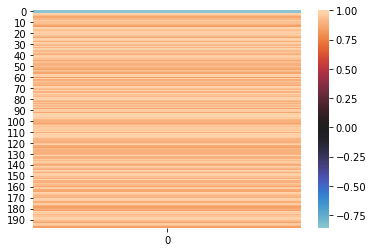

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 74
Task 0 hypothetical scores:


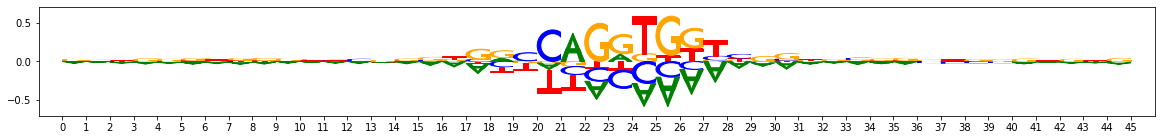

Task 0 actual importance scores:


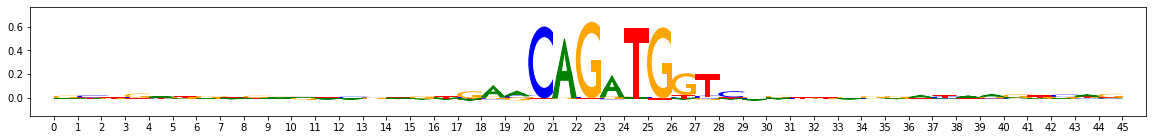

onehot, fwd and rev:


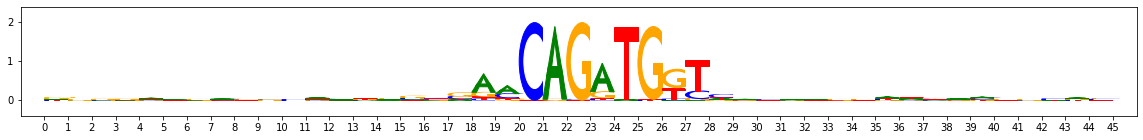

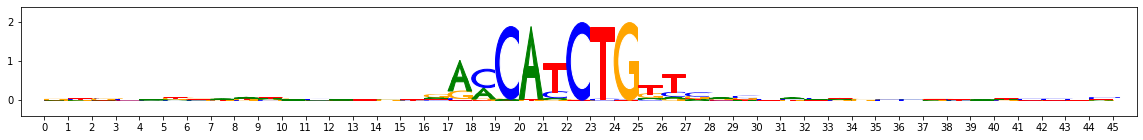

PLOTTING SUBCLUSTERS


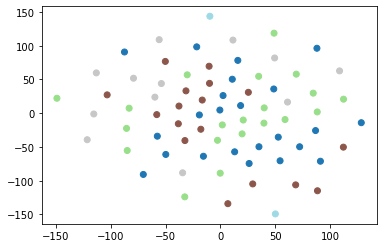

subcluster_0 size 23


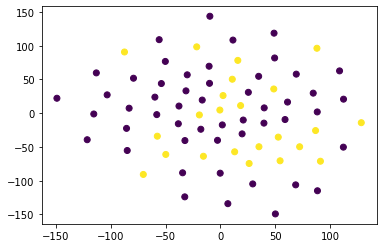

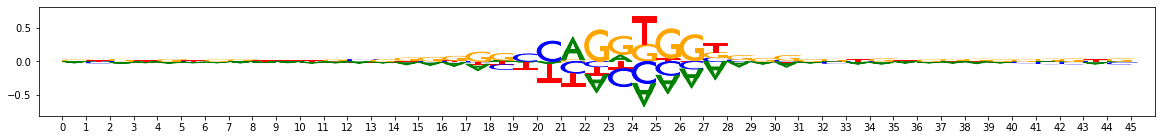

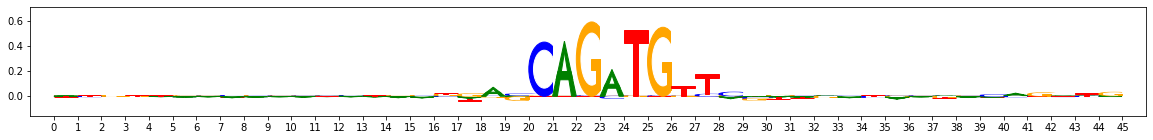

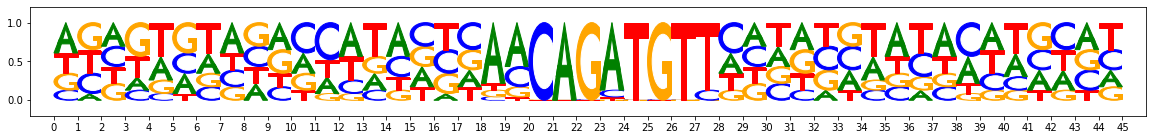

subcluster_1 size 20


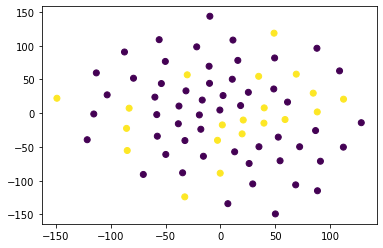

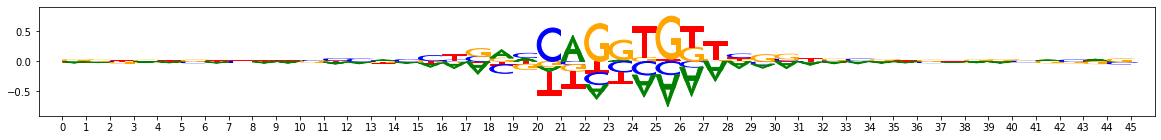

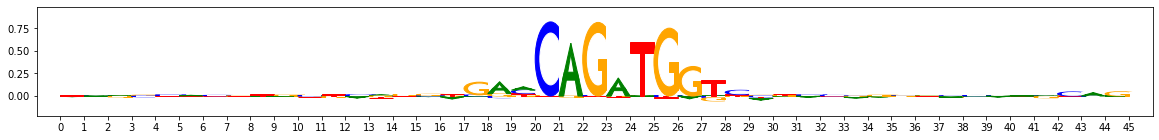

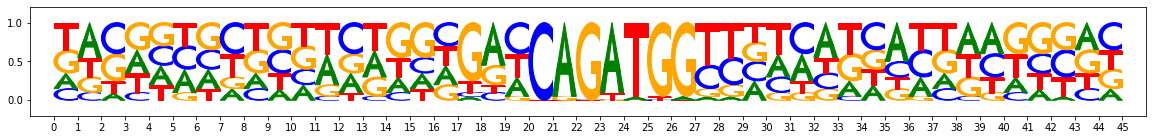

subcluster_2 size 17


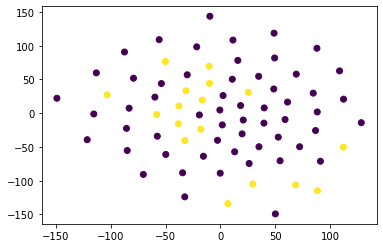

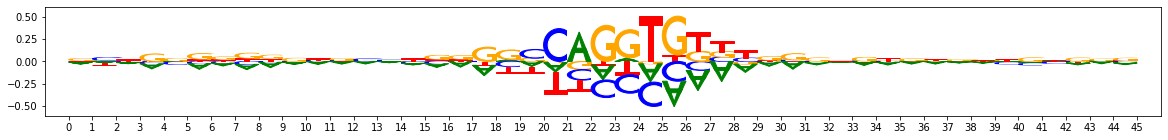

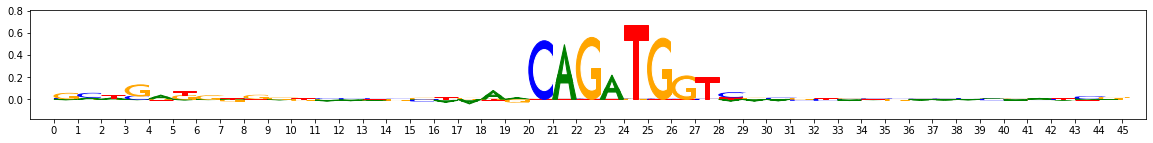

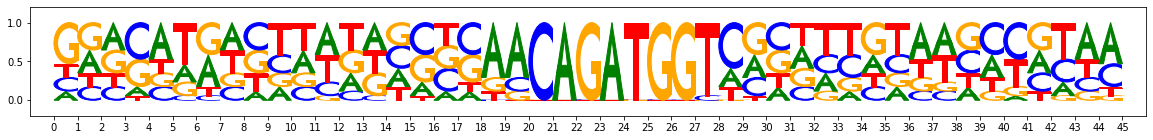

subcluster_3 size 12


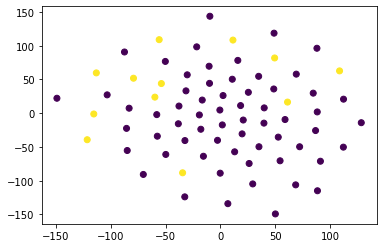

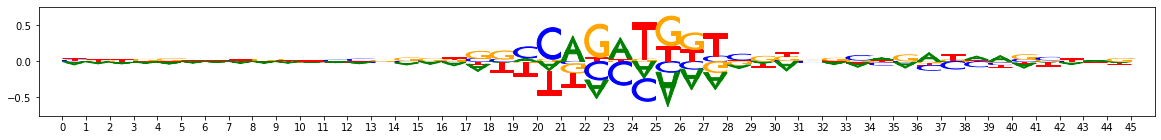

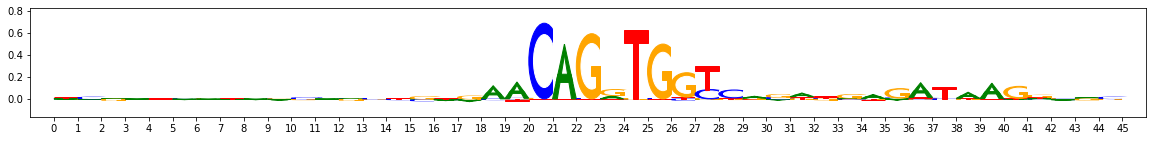

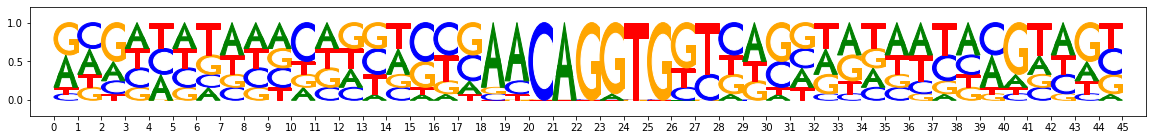

subcluster_4 size 2


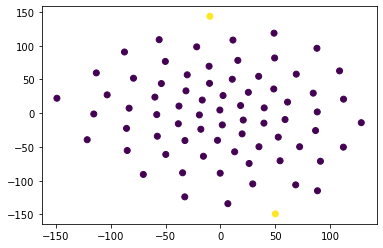

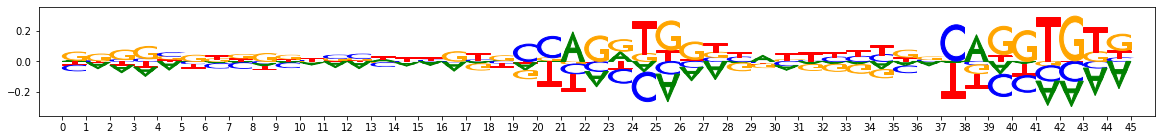

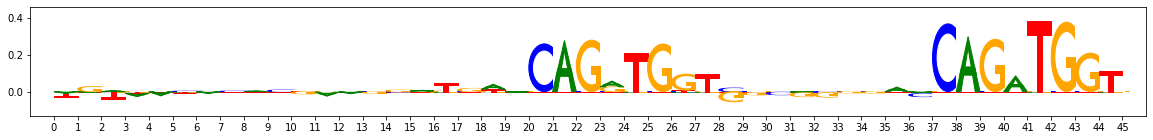

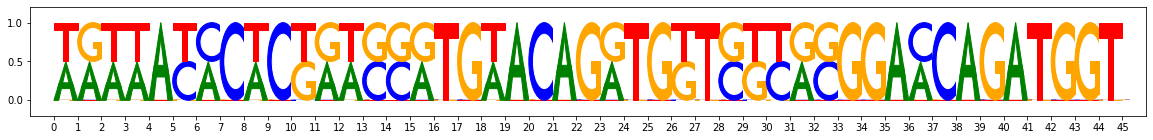

metacluster_0 pattern_1
total seqlets: 75
Task 0 hypothetical scores:


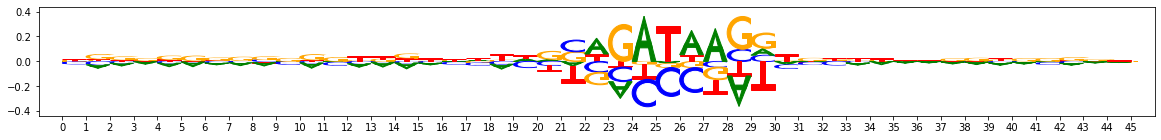

Task 0 actual importance scores:


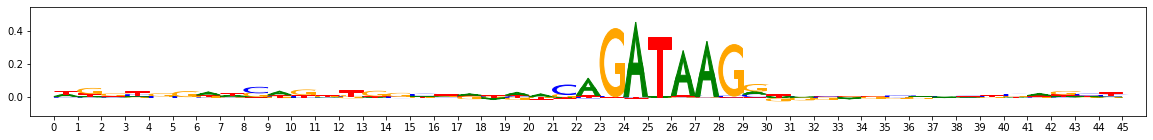

onehot, fwd and rev:


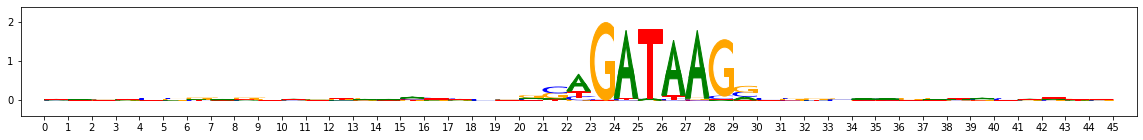

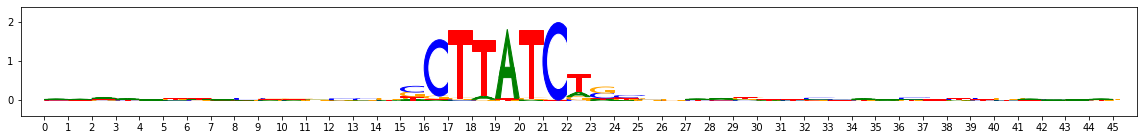

PLOTTING SUBCLUSTERS


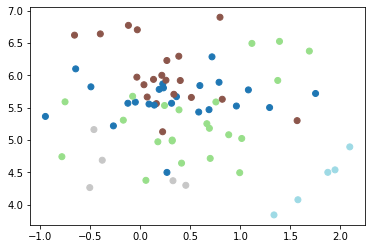

subcluster_0 size 23


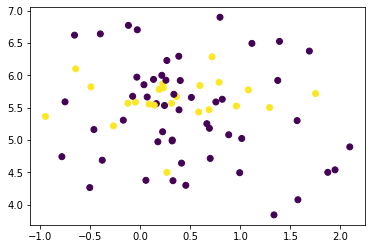

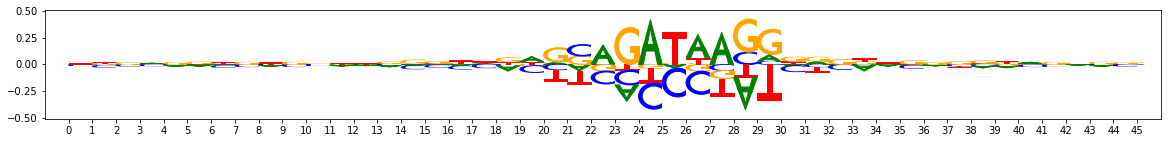

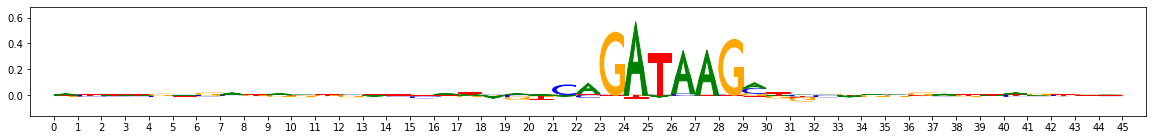

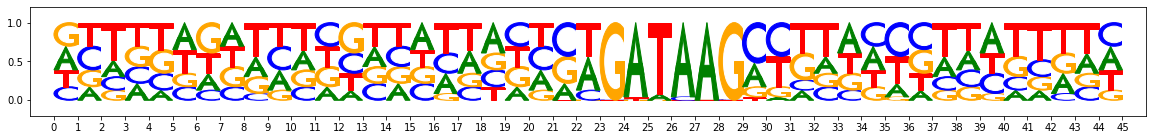

subcluster_1 size 22


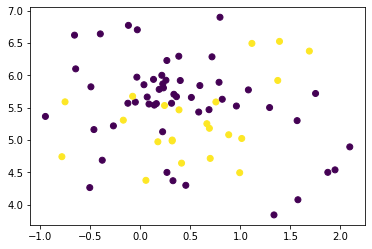

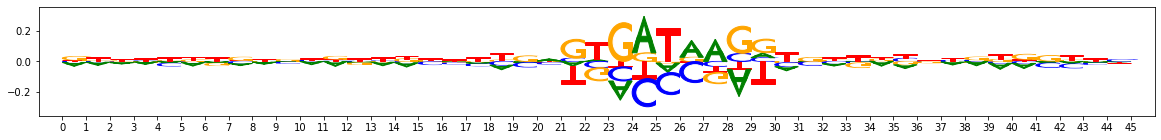

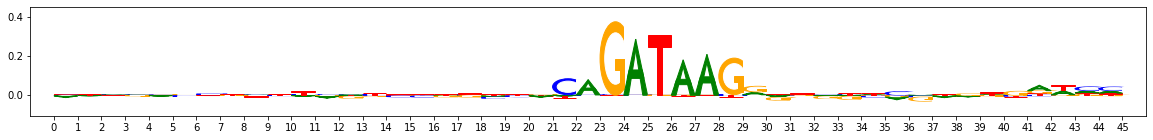

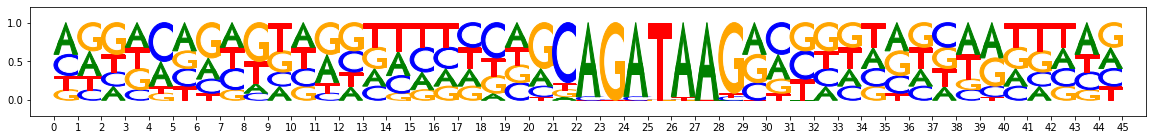

subcluster_2 size 20


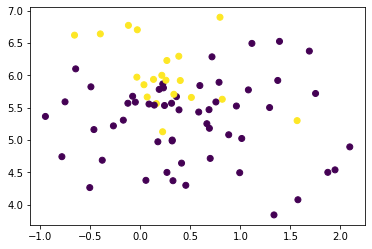

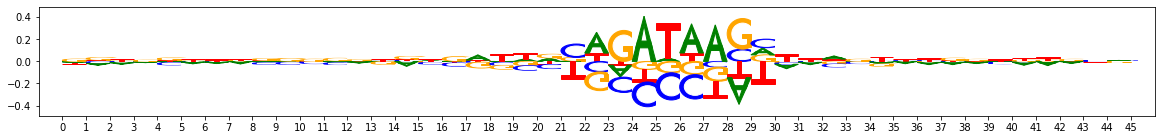

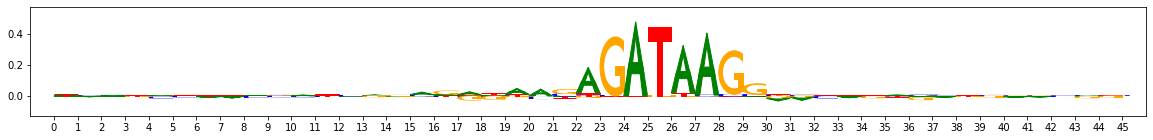

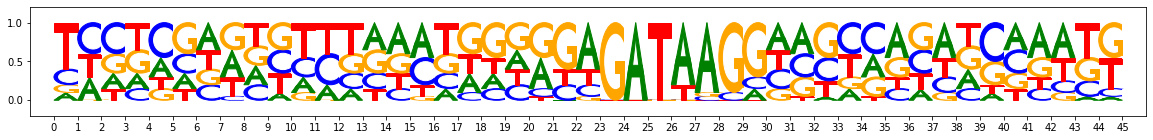

subcluster_3 size 5


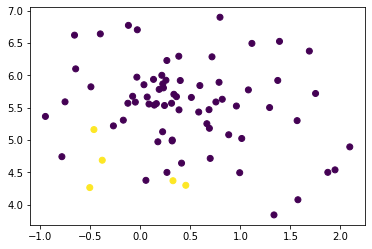

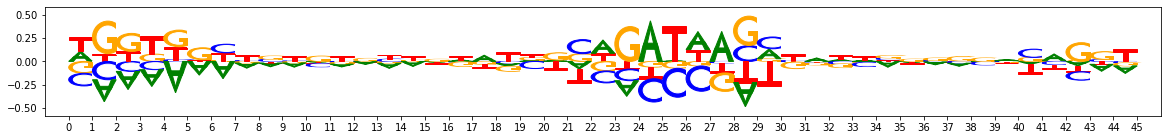

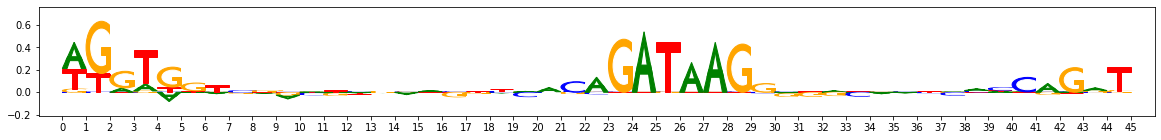

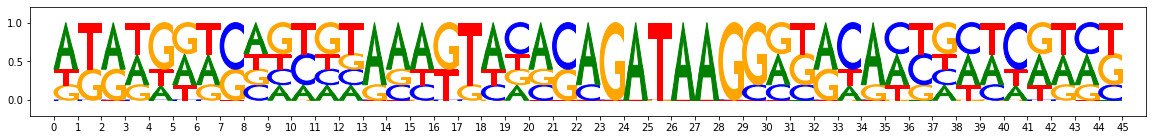

subcluster_4 size 5


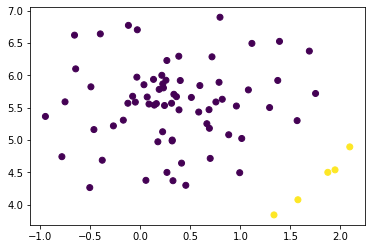

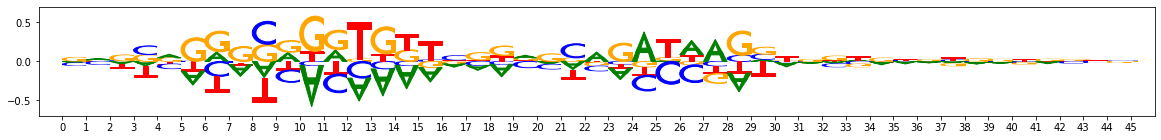

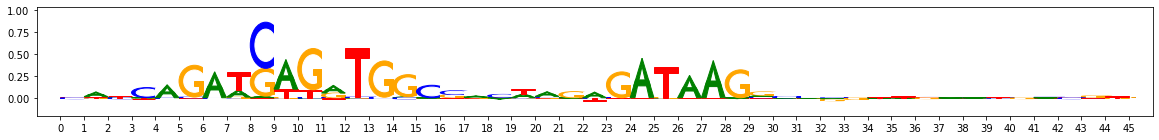

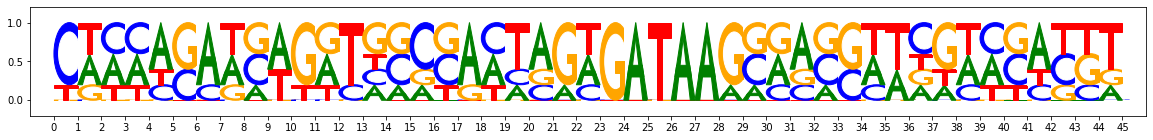

In [15]:
from collections import Counter
import numpy as np

from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        #print("Task 1 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        #print("Task 1 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        #print("Task 2 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        #print("Task 2 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        #Plot the subclustering too, if available
        if ("subclusters" in pattern):
            print("PLOTTING SUBCLUSTERS")
            subclusters = np.array(pattern["subclusters"])
            twod_embedding = np.array(pattern["twod_embedding"])
            plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=subclusters, cmap="tab20")
            plt.show()
            for subcluster_name in list(pattern["subcluster_to_subpattern"]["subcluster_names"]):
                subpattern = pattern["subcluster_to_subpattern"][subcluster_name]
                print(subcluster_name.decode("utf-8"), "size", len(subpattern["seqlets_and_alnmts"]["seqlets"]))
                subcluster = int(subcluster_name.decode("utf-8").split("_")[1])
                plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
                plt.show()
                viz_sequence.plot_weights(subpattern["task0_hypothetical_contribs"]["fwd"])
                viz_sequence.plot_weights(subpattern["task0_contrib_scores"]["fwd"])
                viz_sequence.plot_weights(subpattern["sequence"]["fwd"])
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [16]:
import h5py
import numpy as np
from importlib import reload
import modisco
reload(modisco.util)
reload(modisco.core)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

#If loading from a file for which subclusters haven't been computed (e.g. a file produced by an
# earlier version of modisco), you can compute the subclusters by
# following this template:
#patterns = (loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results["metacluster_0"]
#            .seqlets_to_patterns_result.patterns)
#for pattern in patterns:
#    pattern.compute_subclusters_and_embedding(
#                 pattern_comparison_settings=modisco.affinitymat.core.PatternComparisonSettings(                         
#                    track_names=["task0_hypothetical_contribs", "task0_contrib_scores"],                      
#                    track_transformer=modisco.affinitymat.L1Normalizer(),
#                    min_overlap=None), #min_overlap argument is irrelevant here    
#                 perplexity=30, n_jobs=4, verbose=True)

## Do hit scoring
The hit scoring strategy is still in development. For the previous hit scoring strategy, see the version at tag [v0.5.3.1](https://colab.research.google.com/github/kundajelab/tfmodisco/blob/v0.5.3.1/examples/simulated_TAL_GATA_deeplearning/(On_Google_Colab)_With_Hit_Scoring_TF_MoDISco_TAL_GATA.ipynb)

### Trim the motifs by information content

Before scanning the sequence for hits to motifs, it is worth trimming the motifs by their information content. Let's demonstrate scanning for the GATA motif. We will first trim the motif.

Untrimmed Gata - sequence (scaled by information content)


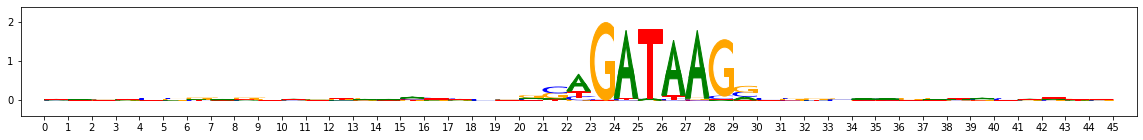

Untrimmed Gata - task 0 hypothetical scores


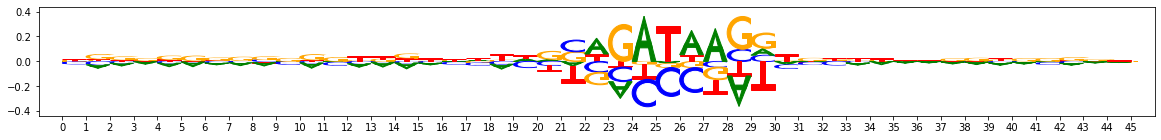

IC-trimmed Gata - sequence (scaled by information content)


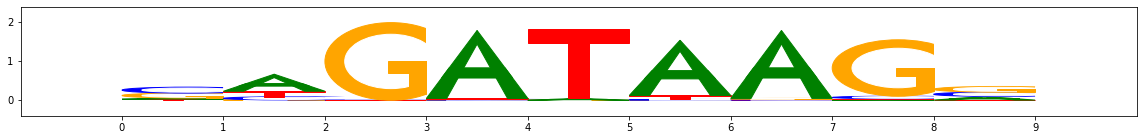

In [17]:
untrimmed_gata_pattern = (
    loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_0"]
    .seqlets_to_patterns_result.patterns[1])
print("Untrimmed Gata - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(untrimmed_gata_pattern["sequence"].fwd, background=background))
print("Untrimmed Gata - task 0 hypothetical scores")
viz_sequence.plot_weights(untrimmed_gata_pattern["task0_hypothetical_contribs"].fwd)
trimmed_gata = untrimmed_gata_pattern.trim_by_ic(ppm_track_name="sequence",
                                                 background=background,
                                                 threshold=0.3)
print("IC-trimmed Gata - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(trimmed_gata["sequence"].fwd, background=background))


Trimming the 45bp GATA motif by information content selected the 9bp subsequence in the range 19-28. Note that the original GATA motif used in the simulation was 10bp long (GATA_disc1 at http://compbio.mit.edu/encode-motifs/ ). Trimming discarded the very first position of that motif, at which there is a weak preference for G followed by A, C and T. Indeed, when we look at the hypothetical importance scores of the untrimmed GATA motif, we see that at position 18 the network has indeed learned a preference for G followed by A, C and T, and that this preference is not apparent when looking at the sequence motif. This reveals an advantage of using the hypothetical importance scores; they can show us the preference of the network even for bases that aren't present in the underlying sequence. In the future, a more principled approaches to doing the trimming based on the hypothetical importance scores could be developed. For now, we will proceed with the version of the motif that has been trimmed by information content.

### Perform scanning with the trimmed motif

Having trimmed the motif, we will scan the importance score tracks with it. We will compute two kinds of scores. The first ("masked hCWM cosine similariy") measures the similarity of the importance scores to the motif (irrespective of the magnitude of the scores), and the second measures the total importance within the window of the motif. Information from both scores will be used to call hits.

#### Masked hCWM cosine similarity

The masked hCWM cosine similarity is used to gauge the similarity between a TF-MoDISco motif and the contribution scores present at a given window of the input sequence, irrespective of the magnitude of the scores. It is best illustrated with an example. Consider the GATA hypothetical contribution weight matrix (hereby referred to as the hCWM) below (the exact values may not be up to date with the rest of the notebook but are meant to be illustrative):
```
>>> print(trimmed_gata["task0_hypothetical_contribs"].fwd)
[[-0.03782349  0.09118378  0.070142   -0.12350229]
 [ 0.1215808  -0.08301942 -0.09632582  0.05776444]
 [-0.1386668  -0.10839121  0.2793305  -0.03227249]
 [ 0.34087033 -0.20777264 -0.02217297 -0.11092472]
 [-0.01404373 -0.21645161 -0.04688007  0.27737541]
 [ 0.1804657  -0.184394   -0.0562734   0.0602017 ]
 [ 0.24564405 -0.04153355 -0.09036025 -0.11375025]
 [-0.23648668  0.09994425  0.25375557 -0.11721314]
 [ 0.05861893  0.04707453  0.10303728 -0.20873074]]
```

Imagine we wanted to use this to score the sequence `CCGATTCGG`. We could take the cosine similarity between the GATA hCWM and the hypothetical importance scores at `CCGATTCGG`. Empirically, however, we have found that over-reliance on hypothetical importance scores - without grounding in the bases that are actually present in the sequence - can yield false positives. We could take the cosine similarity between the GATA hCWM and the actual contribution scores at `CCGATTCGG`, but this is an unsatisfactory solution because the actual contribution scores at `CCGATTCGG` only have nonzero values at the bases that are actually present at each position in the sequence, whereas the GATA hCWM has nonzero values for all bases at all positions. Instead, we *mask* the hCWM to only consider the bases corresponding to `CCGATTCGG`. Concretely, when scannign the sequence `CCGATTCGG`, we use the following masked hCWM:

```
[[ 0.0         0.09118378  0.0         0.0       ]
 [ 0.0        -0.08301942  0.0         0.0       ]
 [ 0.0         0.0         0.2793305   0.0       ]
 [ 0.34087033  0.0         0.0         0.0       ]
 [ 0.0         0.0         0.0         0.27737541]
 [ 0.0         0.0         0.0         0.0602017 ]
 [ 0.0        -0.04153355  0.0         0.0       ]
 [ 0.0         0.0         0.25375557  0.0       ]
 [ 0.0         0.0         0.10303728  0.0       ]]
```
Our similarity score for `CCGATTCGG` will then be the cosine similarity between the masked hCWM above and the contribution scores present at `CCGATTCGG`. The masking is done separately for each window scanned. You can refer to the code for how this is achieved efficiently using numpy stride tricks.

#### Sum of scores in window

This simply consists of taking the sum of the contribution scores in a given window of the input sequence. Looking at the total contribution is useful for identifying motif hits that may look like a good match if you only considered the local sequence, but which may not in fact be strongly bound by the TF because the sequence does not have the requisite cofactor motifs. For example, imagine both TAL and GATA need to be present in order for either TF to bind strongly (this logic is encapsulated in prediction task 0 in the simulation, which is a 1 iff both TAL and GATA are present, and a 0 otherwise). Even though a given portion of the sequence may be an excellent match to the GATA motif, we may not want to consider it a strong motif hit if the TAL motif is not also present in the surrounding sequence. The idea is that the neural network will have learned this logic and will give GATA motifs less importance for task 0 if they are present in a sequence that does not also have TAL. We will see an example of this below.


In [18]:
#compute the masked hCWM cosine similarity.
#In the TAL-GATA simulation, only the forward versions of
# the motifs had been embedded for simplicity. But for demonstration purposes, we will scan
# for both the fwd and reverse motif.
#We will use the scores for task 0, which is a 1 iff both the TAL (CAGATG) and GATA (GATAAG)
# motifs are present in the sequence.
imp_scores = np.array(task_to_scores["task0"])
onehot_seq = np.array(onehot_data)
fwd_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed_gata["task0_hypothetical_contribs"].fwd)
rev_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed_gata["task0_hypothetical_contribs"].rev)

#We take the max of the masked_cosine_sim on the fwd and reverse strands
is_fwd_masked_cosine_sim = fwd_masked_cosine_sim > rev_masked_cosine_sim
masked_cosine_sim = (fwd_masked_cosine_sim*is_fwd_masked_cosine_sim
                     + rev_masked_cosine_sim*(is_fwd_masked_cosine_sim==False))

#Also look at the total sum of scores in each window
sum_scores = modisco.util.compute_sum_scores(imp_scores=imp_scores,
                                             window_size=len(trimmed_gata["task0_hypothetical_contribs"].fwd))

Visualize the 2-d scatterplot for both masked_cosine_sim and sum_scores

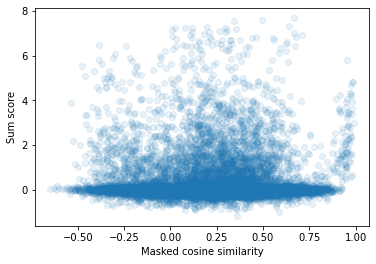

In [19]:
#note that if you have a large number of datapoints here, you would likely want to subsample
# from the arrays. This can be achieved with, e.g. masked_cosine_sim.ravel()[::sumsample_factor]
# you may also want to decrease alpha on the scatterplot. In matplotlib, alpha can be as low as 0.002
plt.scatter(masked_cosine_sim.ravel(), sum_scores.ravel(), alpha=0.1)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.show()

To decide where to draw the threshold, it is useful to visualize the 1-d histogram for "masked_cosine_sim"

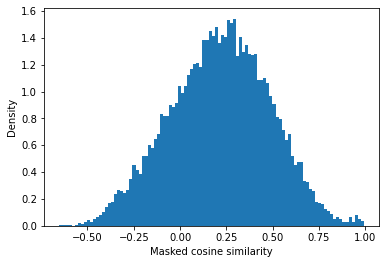

In [20]:
plt.hist(masked_cosine_sim.ravel(), bins=100, density=True)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Density")
plt.show()

It looks like a threshold of around 0.85 would work well for the "masked cosine similarity axis". Applying this threshold and then looking at the distribution for "sum scores" yields:

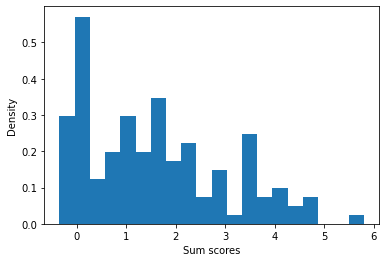

In [21]:
masked_cosine_sim_thresh = 0.85
plt.hist(sum_scores.ravel()[masked_cosine_sim.ravel() > masked_cosine_sim_thresh],
         bins=20, density=True)
plt.xlabel("Sum scores")
plt.ylabel("Density")
plt.show()

The best choice of threshold is an open research question and depends on how strong you would like the matches to be. For demonstration purposes, we will use the threshold of 2 on sum_scores, which is on the stringent side. The threshold of 2 might miss what could be considered "weak affinity" binding sites. Let us visualize the retained hits on a 2d scatterplot:

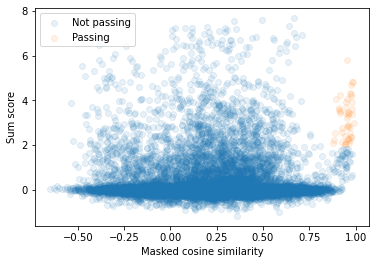

In [22]:
sum_score_thresh = 2
threshold_passers = ((masked_cosine_sim > masked_cosine_sim_thresh)*
                     (sum_scores > sum_score_thresh))
handles = []
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers==False].ravel(),
            sum_scores[threshold_passers==False].ravel(), alpha=0.1))
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers].ravel(),
            sum_scores[threshold_passers].ravel(), alpha=0.1))
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.legend(handles=handles, labels=["Not passing", "Passing"])
plt.show()

From our retained hits, let us visualize the first few matches to the GATA motif.

cosine similarity: 0.9730466132159148 sum scores: 4.67945


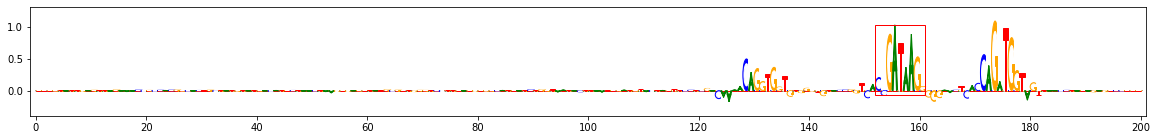

cosine similarity: 0.9718488473936472 sum scores: 4.3328032


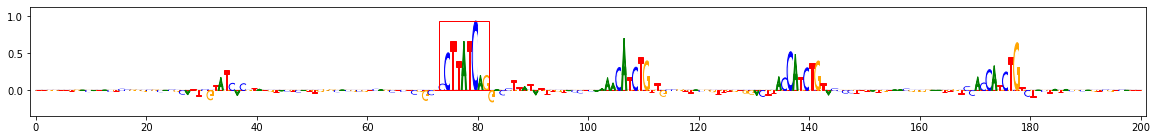

cosine similarity: 0.92635470334193 sum scores: 2.7548823


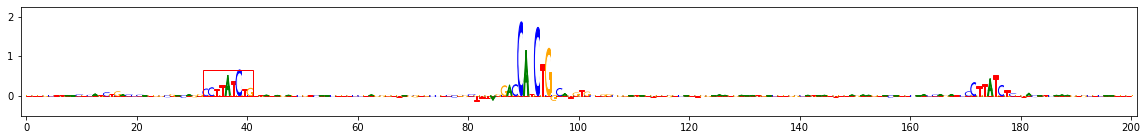

cosine similarity: 0.9739376413725628 sum scores: 2.3730216


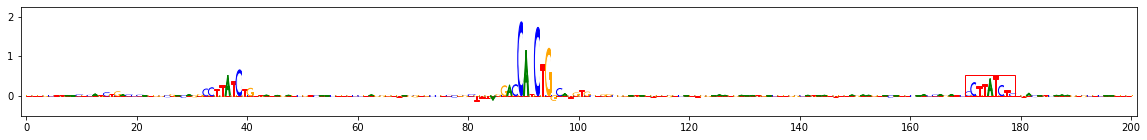

cosine similarity: 0.9107049245615534 sum scores: 3.638939


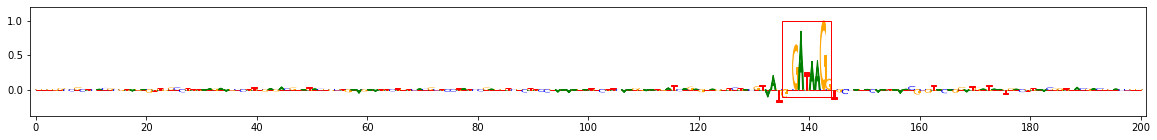

In [23]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
num_to_viz = 5
for (seq_idx, hit_pos) in hit_locations[:num_to_viz]:
    print("cosine similarity:", masked_cosine_sim[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    viz_sequence.plot_weights(
        imp_scores[seq_idx],
        highlight={'red': [(hit_pos, hit_pos+len(trimmed_gata))]},
        subticks_frequency=20)


Let us also visualize some regions that are very strong matches to the log-odds PWM, but which did not have a sufficiently high value for sum_scores and were thus not called as matches at our chosen sum_scores threshold (which was on the stringent sides). It turns out that these regions tend to lack the TAL (CAGATG) motif. Since task 0 is a 1 iff both TAL and GATA motifs are present in the sequence, it makes sense that GATA motifs in the absence of TAL would receive lower importance. This illustrates how looking at the importance scores at motif instances incorporates information about the surrounding context, such as the presence or absence of cofactors.

logodds pwm score: 8.049250092863117 sum scores: 1.6806582


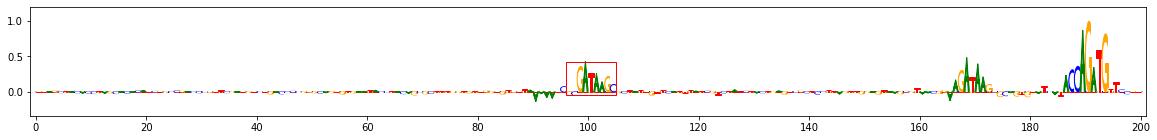

logodds pwm score: 8.038079095629165 sum scores: 1.7580922


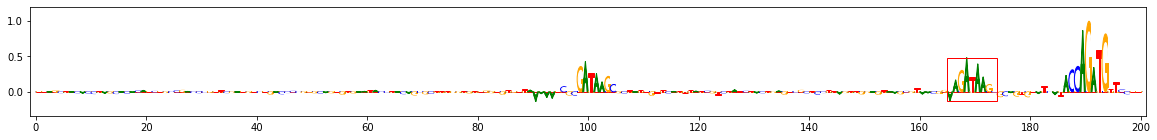

logodds pwm score: 9.27711663216828 sum scores: 1.5461156


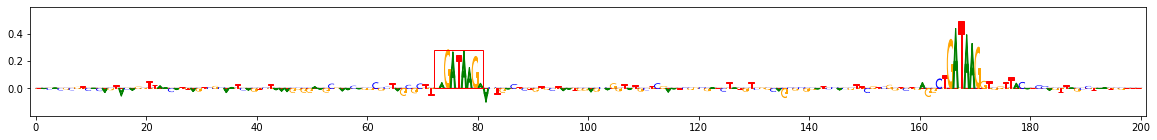

logodds pwm score: 10.0680721367655 sum scores: 1.2932366


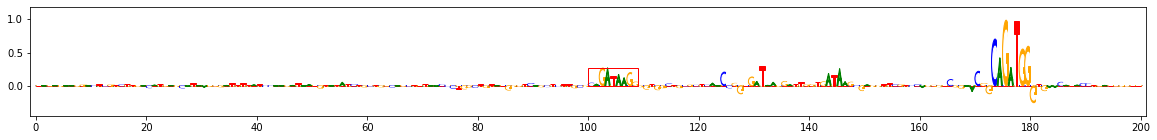

logodds pwm score: 8.758303189768567 sum scores: 0.49651676


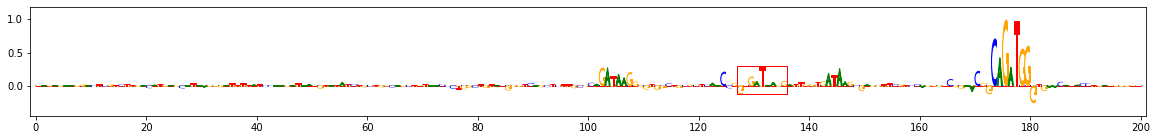

In [24]:
#To compute scores from a simple log-odds pwm scan, we can use the code below
# Note that because the simulation was generated using a position probability matrix (ppm), the scanning
# with the log-odds pwm works better than the masked cosine similarity.
#However, in-vivo TF binding is more complex than what can be characterized by a log-odds pwm - 
# see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3936734/
logodds_pwm = modisco.util.get_logodds_pwm(ppm=trimmed_gata["sequence"].fwd,
                                           background=background, pseudocount=0.001)
#For simplicity, we will only compute the scores for the forward version of the
# motif since that was what was used in the simulation.
fwd_logodds_pwm_scores = modisco.util.compute_pwm_scan(onehot_seq=onehot_seq,
                                                weightmat=logodds_pwm)
lower_imp_gata_hit_locations = list(zip(*np.nonzero((fwd_logodds_pwm_scores > 8)
                                                    *(sum_scores < sum_score_thresh))))
for (seq_idx, hit_pos) in lower_imp_gata_hit_locations[:num_to_viz]:
    print("logodds pwm score:", fwd_logodds_pwm_scores[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    viz_sequence.plot_weights(
        imp_scores[seq_idx],
        highlight={'red': [(hit_pos, hit_pos+len(trimmed_gata))]},
        subticks_frequency=20)

## Inspect the pattern merging hierarchy

Inspect the hierarchy of motif merging events that led to the final motif. Read "Path to node" like a directory structure; all motifs at a similar level in the hierarchy (except for the topmost level) were collapsed together. Any motifs at the topmost level for which the number of seqlets was less than `final_min_cluster_size` were disbanded, and their seqlets were reassigned to the dominant motifs (provided the similarity passed a threshold)

For metacluster 0
Path to node: root/0
Number of seqlets 74


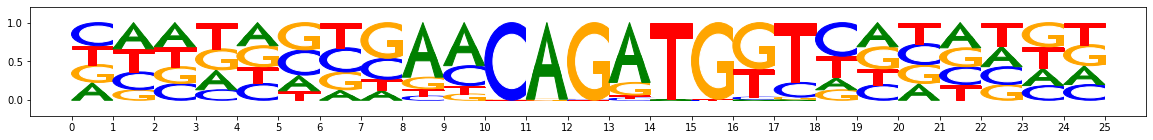

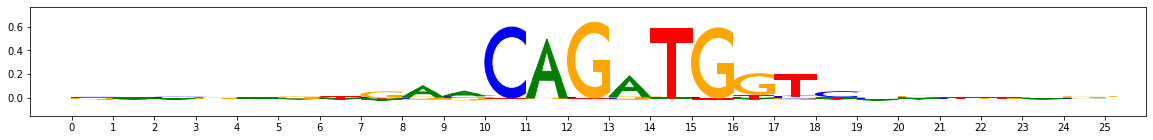

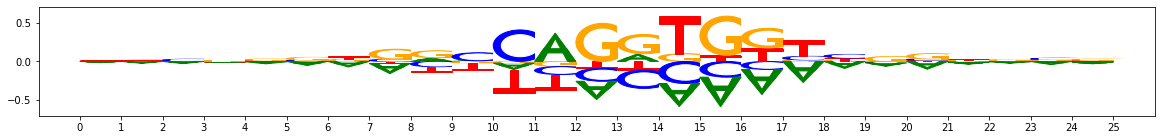

Path to node: root/0/0
Number of seqlets 43


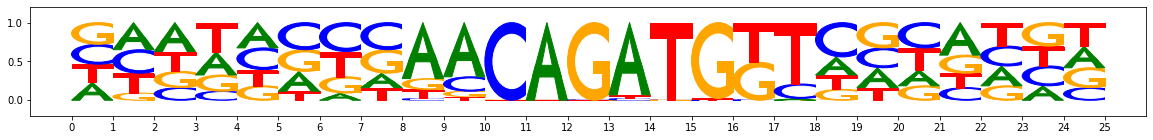

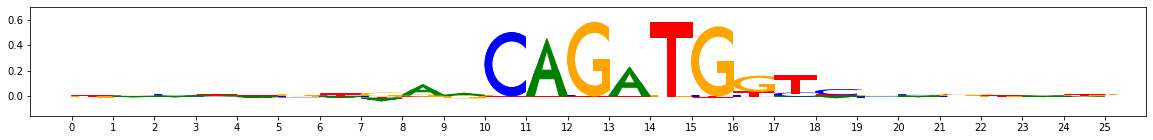

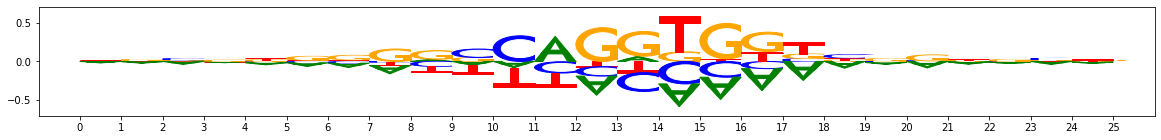

Path to node: root/0/1
Number of seqlets 33


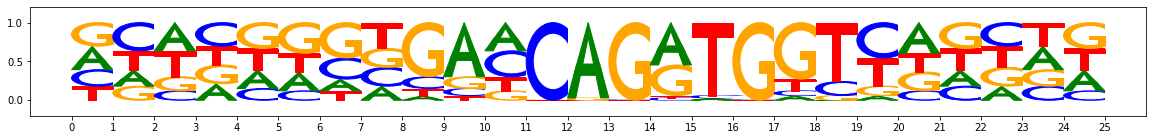

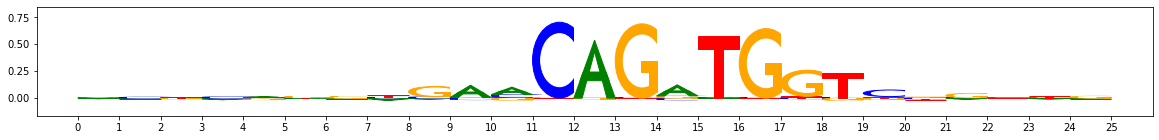

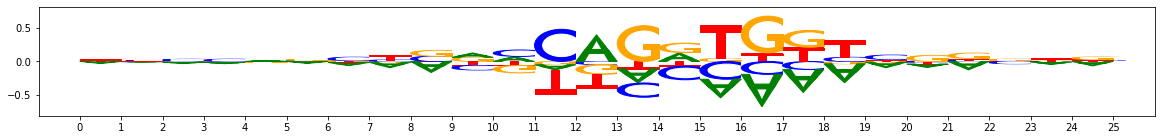

Path to node: root/1
Number of seqlets 72


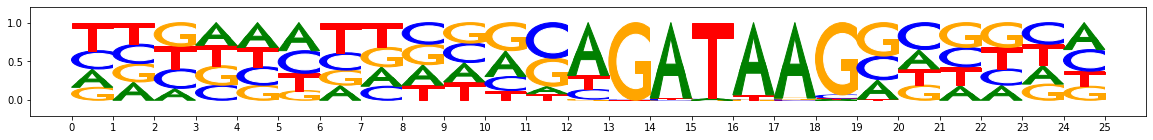

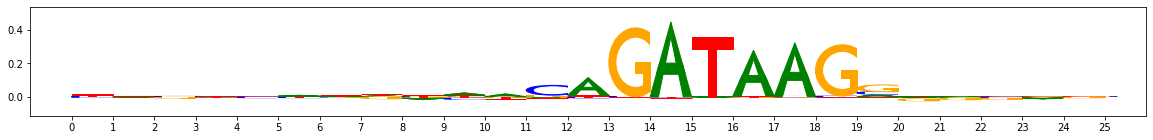

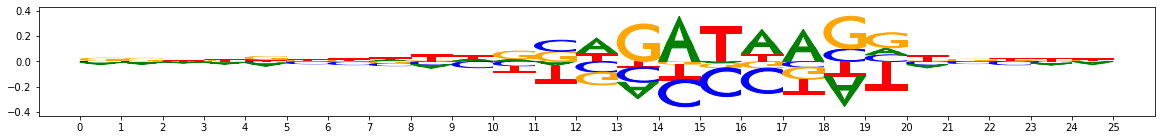

Path to node: root/1/0
Number of seqlets 51


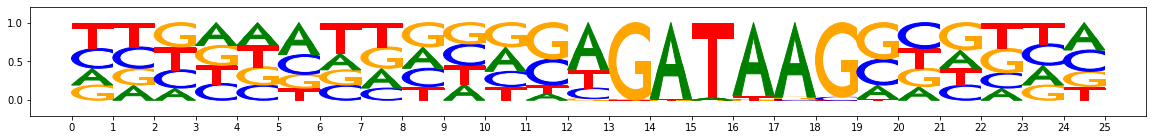

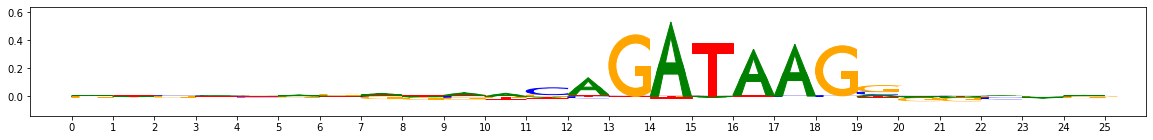

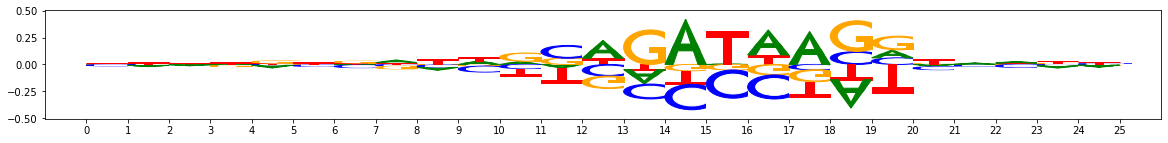

Path to node: root/1/1
Number of seqlets 21


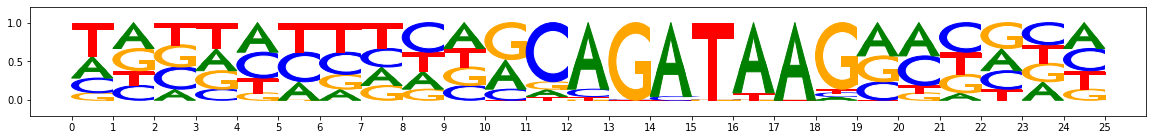

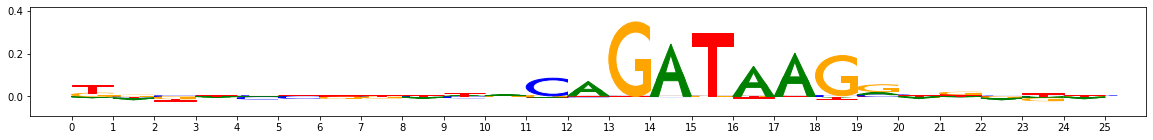

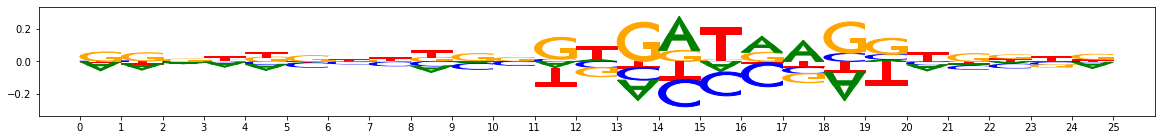

Path to node: root/2
Number of seqlets 3


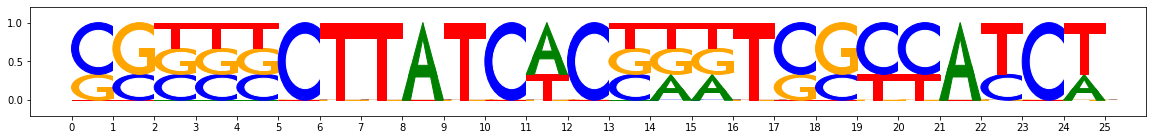

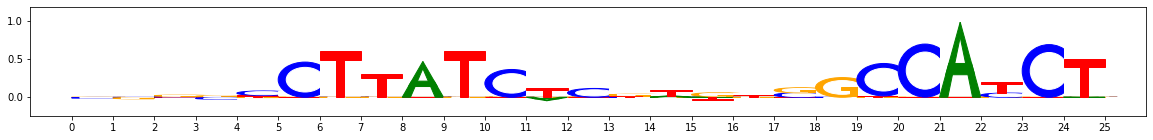

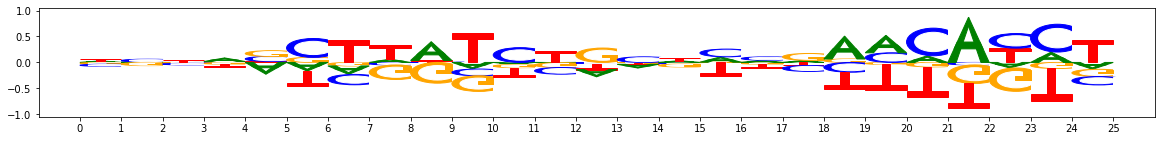

Path to node: root/3
Number of seqlets 1


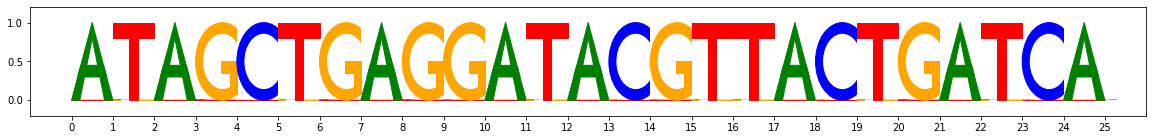

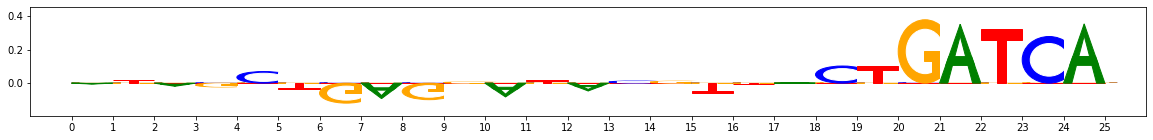

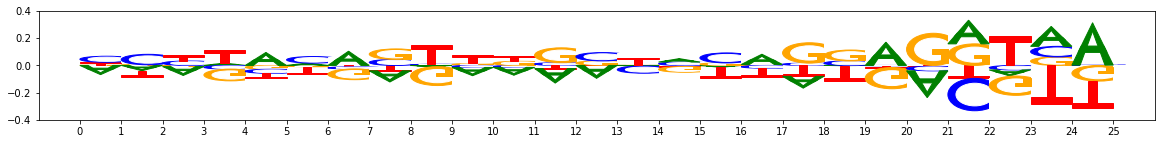

In [25]:
def recursive_plot_hierarchy_motifs(nodes, path):
    for i in range(len(nodes)):
        nodepath = path+"/"+str(i)
        print("Path to node:",nodepath)
        print("Number of seqlets",len(nodes[i].pattern.seqlets))
        if (nodes[i].indices_merged is not None):
            #indices_merged, submat_crosscontam and submat_alignersim can
            # be used to inspect the steps in the merging
            #print("indices merged:",nodes[i].indices_merged)
            #print("submat crosscontam:\n",nodes[i].submat_crosscontam)
            #print("submat alignersim:\n",nodes[i].submat_alignersim)
            pass
        
        #For plotting figures to a png, this code can be used...
        #fig = plt.figure(figsize=(20,5))                                           
        #ax = fig.add_subplot(111)
        #viz_sequence.plot_weights_given_ax(ax, nodes[i].pattern["sequence"].fwd)
        #plt.savefig(nodepath+".png")
        
        viz_sequence.plot_weights(nodes[i].pattern["sequence"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_hypothetical_contribs"].fwd)
        recursive_plot_hierarchy_motifs(nodes[i].child_nodes, path=nodepath)

print("For metacluster 0")
recursive_plot_hierarchy_motifs(loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_0"]
    .seqlets_to_patterns_result.pattern_merge_hierarchy.root_nodes,
    path="root")